<a href="https://colab.research.google.com/github/Dare-Badejo-001/BioSteam-TEA-LCA/blob/main/Process_development_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install biosteam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.5/429.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 9.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.6/936.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 19.2 MB/s eta 0

In [5]:
from biosteam import settings, Chemical, Stream, units, main_flowsheet
import biosteam as bst;
bst.nbtutorial()

## Denature EthOH Fuel in a BioEthOH Process

In [6]:
# first name a new flowsheet
main_flowsheet.set_flowsheet('mix_ethanol_with_denaturant')

# set the themodynamic property package
settings.set_thermo(['Water', 'Ethanol', 'Octane'])

# assume 40M gal of ethanol produced a year
# with 330 operating days

dehydrated_ethanol = Stream('dehydrated_ethanol', T=340,
                            Water =0.1, Ethanol=99.9, units='kg/hr')

operating_days_per_year = 330
dehydrated_ethanol.F_vol = 40e6 / operating_days_per_year
denaturant = Stream('denaturant', Octane=1)
M1 = units.Mixer('M1', ins=(dehydrated_ethanol, denaturant), outs='denatured_ethanol')

# create a specification function
@M1.add_specification(run=True) # run mass and energy balance after speficiation function

def adjust_denaturant_flow():
  denaturant_over_ethanol_flow = 0.02 / 0.98 # a mass ratio
  denaturant.imass['Octane'] = denaturant_over_ethanol_flow * dehydrated_ethanol.F_mass

M1.simulate()
M1.show(composition=True, flow='kg/hr')


Mixer: M1
ins...
[0] dehydrated_ethanol  
    phase: 'l', T: 340 K, P: 101325 Pa
    composition (%): Water    0.1
                     Ethanol  99.9
                     -------  9.06e+07 kg/hr
[1] denaturant  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition (%): Octane  100
                     ------  1.85e+06 kg/hr
outs...
[0] denatured_ethanol  
    phase: 'l', T: 339.31 K, P: 101325 Pa
    composition (%): Water    0.098
                     Ethanol  97.9
                     Octane   2
                     -------  9.25e+07 kg/hr


## Prep. Corn Slurry ub Conventional Dry-Grind Process

In [19]:
# Name a new flowsheet
main_flowsheet.set_flowsheet('corn_slurry_case_study')

# Create a general xmical to represent the components of corn
Starch = Chemical.blank('Starch', phase='s')
Fiber = Chemical.blank('Fiber', phase='s')
Oil = Chemical.blank('Water', phase='l')
Water = Chemical.blank('Water', phase='l')

# assume properties
Starch.default()
Fiber.default()
Oil.default()
Water.default()

# set the property pakage
settings.set_thermo([Starch, Oil, Fiber, Water])

# set the throughput and flowrates
yield_of_corn_bushel  = 2.7
corn_flow_per_year = 40e6 / yield_of_corn_bushel
days_per_year  = 365
operating_days_per_year = 355
corn_flow_per_day = corn_flow_per_year / operating_days_per_year

# set up the composition of the corn kernel
corn_feed = Stream('corn_feed',
                   Starch=62, Fiber=19, Water=15, Oil=4,
                   total_flow=corn_flow_per_day,
                   units='bu/day')
T1 = bst.StorageTank('T1', corn_feed)

# create the water stream to be mixed with the milled corn to create slurry
dilution_water = Stream('dilution_water', Water=1)
M1 = units.Mixer('M1', ins=(dilution_water, T1-0), outs='slurry')

@M1.add_specification(run=True, #run the mass and energy balance
                      args=[0.32] #paa adjusted_water_flow
)


def adjust_water_flow(solids_content):
  F_mass_moisture = corn_feed.imass['Water']
  F_mass_solids = corn_feed.F_mass - F_mass_moisture
  water_solids_ratio = (1 - solids_content) / (solids_content)
  dilution_water.imass['Water'] = F_mass_solids * water_solids_ratio

#simulate and check results
corn_slurry_sys = main_flowsheet.create_system('corn_slurry_sys')
corn_slurry_sys.simulate
M1.show(flow='kg/hr', composition=True)


UndefinedChemicalAlias: 'Oil'

## Flash Design Specification

In [20]:
main_flowsheet.set_flowsheet('flash_spec')


#set the thermo ppty package
settings.set_thermo(['Water', 'Ethanol', 'Propanol'])

# Feed Stream
mixture = Stream('mixture', T=340,
                 Water =1000, Ethanol= 1000, Propanol= 1000,
                 units='kg/hr')

# Flash Vessel
F1 = units.Flash('F1',
                 ins=mixture,
                 outs=('vapor', 'liquid'),
                 T=373,
                 P = 101325
                 )

# set a numerical specification to solve the obj function when called
@F1.add_bounded_numerical_specification(x0=351.4, x1=373, xtol=1e-9, ytol=1e-3)

def f(x):
  # Objective function where f(x) = 0 at a
  # vapor fraction of 50 wt. %
  F1.T = x
  F1.run()  # run the mass and energy balance at the new condition
  feed = F1.ins[0]
  vapor = F1.outs[0]
  V= vapor.F_mass/ feed.F_mass
  return V - 0.5


# Now create the system , simulate and check results

system = main_flowsheet.create_system()
system.simulate()
system.diagram()


In [22]:
vapor_mass_fraction = (F1.outs[0].F_mass / mixture.F_mass) * 100
print('Vapor mass fraction is {:.2f}%'.format(vapor_mass_fraction))

Vapor mass fraction is 49.81%


# Inheriting from Units

In [29]:
# we inherit from a unit class and use it to create a boiler
# this is used to build a unit operations

import biosteam as bst
from math import ceil
bst.nbtutorial()

class Boiler(bst.Unit):
  '''
  Create the boiler object :
  Role: to partially boil feed

  Parameters
  ----------
  ins :
    Inlet fluids

  outs:
    *[0] vapor product
    *[1] liquid product

  V : float
      Molar vapor fraction
  P: float
      Operating pressure [Pa]
  '''

  _N_ins = 1 # Number of inlet streams
  _N_outs = 2 # Number of outlet streams
  _units = {'Area' :'m^2'}


  def _init(self, V, P):
    # The _init methods adds input parameters for unit creation
    self.V = V  # molar vapor fraction
    self.P = P  # operating pressure [Pa]

  def _run(self):
    # Eqv. to self.ins[0] when the number of inlets is one
    feed = self.feed
    vap, liq = self.outs

    # perform vap-piq equilibrium
    stream = feed.copy()
    stream.vle(V=self.V, P=self.P)

    #update the outlet streams
    vap.copy_like(stream['g'])
    liq.copy_like(stream['l'])

  def _design(self):
    #add heat utility requirement
    T_operation = self.outs[0].T
    duty = self.H_out - self.H_in

    if duty < 0 : raise RuntimeError(f'{repr(self)} is cooling.')
    heat_utility = self.add_heat_utility(duty, T_operation) #New utility is also in self.heat_utilities

    # Temp. of utility at entrance
    T_utility = heat_utility.inlet_utility_stream.T

    # Temp. gradient
    dT = T_utility - T_operation

    # heat transfer coefficient kJ/(hr*m2*k)
    U = 8176.699

    # Area requirement (m^2)
    A = duty/ (U * dT)

    # Maximum area per unit
    A_max = 743.324

    # Number of units
    N = ceil(A / A_max)

    # Design Requirements ( excluding utilities ) are stored here
    self.design_results['Area'] = A / N

    self.parallel['Boiler'] = N


    def _cost(self):
      A = self.design_results['Area']

      #long-tube vertical boiler cost correlation
      purchase_cost = bst.settings.CEPCI * 3.086 * A**0.55

      # itemized purchase costs are stiored here
      self.baseline_purchase_costs['Boiler'] = purchase_cost # Not account for material factor

      # Assume design, pressure and material factors are 1
      self.F_D['Boiler'] = self.F_P['Boiler'] = self.F_M['Boiler'] = 1

      # set bare-module factor for bopilers
      self.F_BM['Boiler'] = 2.45

# Simulation Test

In [30]:
import biosteam as bst
bst.settings.set_thermo(['Water'])
water = bst.Stream('water', Water=300)
B1 = Boiler('B1', ins=water, outs=('gas', 'liq'),
            V=0.5, P=101325)
B1.diagram()
B1.show()

Boiler: B1
ins...
[0] water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  300
outs...
[0] gas  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] liq  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [32]:
B1.simulate()
B1.show()

Boiler: B1
ins...
[0] water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  300
outs...
[0] gas  
    phase: 'g', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  150
[1] liq  
    phase: 'l', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  150


In [33]:
B1.results()

Boiler                      Units       B1
Low pressure steam  Duty    kJ/hr 8.21e+06
                    Flow  kmol/hr      212
                    Cost   USD/hr     50.4
Design              Area      m^2     24.4
Total purchase cost           USD        0
Utility cost               USD/hr     50.4

In [34]:
B1.feed.scale(100)
B1.simulate()
B1.results()

Boiler                      Units       B1
Low pressure steam  Duty    kJ/hr 8.21e+08
                    Flow  kmol/hr 2.12e+04
                    Cost   USD/hr 5.04e+03
Design              Area      m^2      610
Total purchase cost           USD        0
Utility cost               USD/hr 5.04e+03

# Graphviz Attributes

In [36]:
graphics = Boiler._graphics
edge_in = graphics.edge_in
edge_out = graphics.edge_out
node = graphics.node

In [37]:
node

{'shape': 'box',
 'style': 'filled',
 'gradientangle': '0',
 'width': '0.6',
 'height': '0.6',
 'orientation': '0.0',
 'peripheries': '1',
 'margin': 'default',
 'fontname': 'Arial'}

In [39]:
B1.diagram()

In [42]:
def tailor_node_to_unit(node, unit):
  if unit.feed.isempty(): node['label'] += '\n-empty-'

graphics.tailor_node_to_unit = tailor_node_to_unit
B1.diagram()

# Cost Decorator

In [43]:
# This adds a free on board purhcase cost based on the exponential scale up equation

from biosteam.units.decorators import cost

chemicals = bst.Chemicals(['Water', 'Ethanol'])
SugarCane = bst.Chemical.blank('SugarCane', phase_ref='s')
SugarCane.default()
chemicals.append(SugarCane)
bst.settings.set_thermo(chemicals)

# for year 2018
bst.CE = 603.1


# basis will be the totla flwo rate in kg/hr
@cost('Flow rate', units='kg/hr', cost=2.5e6, CE=567.3,
      n=0.6, S=500e3, kW=3000, BM=1.39, lifetime=30)

class Shredder(bst.Unit): pass
# Units without a '_run' method assume one inpyt and output stream
# that share the same flow rates and  conditions


## Test the shredder object

bst.Stream.display_units.flow = 'kg/hr'

feed = bst.Stream(SugarCane=1e6, units='kg/hr')
shredder = Shredder(ins=feed)
shredder.simulate()

shredder.show()
shredder.results()

Shredder: U1
ins...
[0] s1  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kg/hr): SugarCane  1e+06
outs...
[0] s2  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kg/hr): SugarCane  1e+06


Shredder                        Units       U1
Electricity         Power          kW    6e+03
                    Cost       USD/hr      469
Design              Flow rate   kg/hr    1e+06
Purchase cost       Shredder      USD 4.03e+06
Total purchase cost               USD 4.03e+06
Utility cost                   USD/hr      469

In [44]:
# lets change the cost simulate and see the result again
Shredder.cost_items['Shredder'].cost = 3e6
shredder.simulate()
shredder.results()

Shredder                        Units       U1
Electricity         Power          kW    6e+03
                    Cost       USD/hr      469
Design              Flow rate   kg/hr    1e+06
Purchase cost       Shredder      USD 4.83e+06
Total purchase cost               USD 4.83e+06
Utility cost                   USD/hr      469

In [45]:
Shredder.cost_items['Shredder'].ub = 6e5
shredder.simulate()
shredder.results()

Shredder                            Units       U1
Electricity         Power              kW    6e+03
                    Cost           USD/hr      469
Design              Flow rate       kg/hr    1e+06
Purchase cost       Shredder (x2)     USD 6.38e+06
Total purchase cost                   USD 6.38e+06
Utility cost                       USD/hr      469

In [48]:
# Extending the decorator
@cost('Flow rate', 'Agitator', units='kg/hr', cost=9e4, S=252891, kW=170, CE=522, n=0.5, BM=1.5)

class FlashWithAgitator(bst.Flash):

  def _design(self):
    super()._design()
    self._decorated_design()



  def _cost(self):
    # run falsh cosr algorithm
    super()._cost()

    # run decorated cost algorithm
    self._decorated_cost()

# Test
F1 = FlashWithAgitator('F1', bst.Stream('feed', Water=800, Ethanol=500, T=350),
                       V=0.5, P=101325)
F1.simulate()
F1.results()

Flash with agitator                                   Units            F1
Electricity         Power                                kW          25.2
                    Cost                             USD/hr          1.97
Low pressure steam  Duty                              kJ/hr      2.82e+07
                    Flow                            kmol/hr           728
                    Cost                             USD/hr           173
Design              Vessel type                                  Vertical
                    Length                               ft          12.5
                    Diameter                             ft           8.5
                    Weight                               lb      8.14e+03
                    Wall thickness                       in         0.438
                    Flow rate                         kg/hr      3.74e+04
                    Vessel material                          Carbon steel
Purchase cost       Vertical pressure vessel            USD      4.47e+04
                    Platform and ladders                USD      1.27e+04
                    Agitator                            USD         4e+04
                    Heat exchanger - Floating head      USD      3.65e+04
Total purchase cost                                     USD      1.34e+05
Utility cost                                         USD/hr           175

# Auxilary Units

In [49]:
class HeatedTank(bst.Unit):
    # Define names of auxiliary units
    auxiliary_unit_names = ('mix_tank', 'pump', 'heat_exchanger')

    def _init(self, T):
        pump = self.auxiliary(
            'pump', # name of auxiliary unit
            bst.Pump, # class of auxiliary unit
            ins=self.ins, # inlets to auxiliary unit (can be the same as parent unit)
        )
        heat_exchanger = self.auxiliary(
            'heat_exchanger', # name
            bst.HXutility, # class
            ins=pump.outlet, # outlet from pump is the inlet to heat exchanger
            T=T, #: additional arguments to HXutility (Temperature [K])
        )
        self.auxiliary(
            'mix_tank', # name
            bst.MixTank, # class
            ins=heat_exchanger.outlet, # connect
            outs=self.outs, # outlet from auxiliary unit (can be the same as parent unit)
        )

    def _run(self):
        # Run auxiliary unit operations internally
        self.pump._run()
        self.heat_exchanger._run()
        self.mix_tank._run()

    def _design(self):
        # Explicitly design and cost auxiliaries
        self.pump._design()
        self.heat_exchanger._design()
        self.mix_tank._design()

    def _cost(self):
        self.pump._cost()
        self.heat_exchanger._cost()
        self.mix_tank._cost()


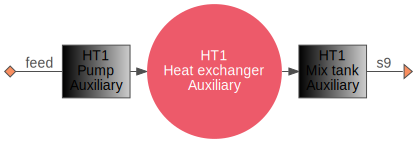

HeatedTank: HT1
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kg/hr): Water  3.6e+03
outs...
[0] s9  
    phase: 'l', T: 310 K, P: 101325 Pa
    flow (kg/hr): Water  3.6e+03


Heated tank                                         Units      HT1
Electricity         Power                              kW    0.736
                    Cost                           USD/hr   0.0575
Low pressure steam  Duty                            kJ/hr 1.88e+05
                    Flow                          kmol/hr     4.86
                    Cost                           USD/hr     1.15
Purchase cost       Mix tank - Tank                   USD 3.07e+04
                    Pump - Pump                       USD 4.64e+03
                    Pump - Motor                      USD      290
                    Heat exchanger - Double pipe      USD 3.84e+03
Total purchase cost                                   USD 3.94e+04
Utility cost                                       USD/hr     1.21

In [50]:
feed = bst.Stream('feed', Water=200)
HT1 = HeatedTank('HT1', ins=feed, T=310)
HT1.simulate()
HT1.diagram(format='svg')
HT1.show()
HT1.results()

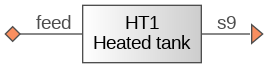

In [51]:
HT1.diagram(auxiliaries=0, format='png')